In [1]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nbme-score-clinical-patient-notes/sample_submission.csv
/kaggle/input/nbme-score-clinical-patient-notes/patient_notes.csv
/kaggle/input/nbme-score-clinical-patient-notes/features.csv
/kaggle/input/nbme-score-clinical-patient-notes/train.csv
/kaggle/input/nbme-score-clinical-patient-notes/test.csv


In [2]:
!pip install stylecloud

     |████████████████████████████████| 262 kB 4.4 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 161 kB 65.7 MB/s            
     |████████████████████████████████| 87 kB 5.2 MB/s             
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 87 kB 4.7 MB/s             
  Preparing metadata (setup.py) ... - done
  Created wheel for stylecloud: filename=stylecloud-0.5.2-py3-none-any.whl size=259508 sha256=176fac9d38ce059f1626f2f7bd38291fe6d85c3019f7825d72979636653ba634
  Stored in directory: /root/.cache/pip/wheels/77/42/7a/f52b5f84c04196fd4c2a3dceeb1bbeaee1c93a4fe271b5eb41
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=1ec1c69d7b8948699f616dc280b8229466a97e954993546427d4f6243244d86b
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
  Created wheel for tinycss: filename=tinycss-0.4-py3-none-any.whl s

 <h1 align='center'>Dataset Info



## Training data
**patient_notes.csv - A collection of about 40,000 Patient Note history portions.**

* ```pn_num``` - A unique identifier for each patient note.
* ```case_num``` - A unique identifier for the clinical case a patient note represents.
* ```pn_history``` - The text of the encounter as recorded by the test taker.

**features.csv - The rubric of features (or key concepts) for each clinical case.**

* ```feature_num``` - A unique identifier for each feature.
* ```case_num``` - A unique identifier for each case.
* ```feature_text``` - A description of the feature.

**train.csv - Feature annotations for 1000 of the patient notes, 100 for each of ten cases.**

* ```id``` - Unique identifier for each patient note / feature pair.
* ```pn_num``` - The patient note annotated in this row.
* ```feature_num``` - The feature annotated in this row.
* ```case_num``` - The case to which this patient note belongs.
* ```annotation``` - The text(s) within a patient note indicating a feature. A feature may be indicated multiple times within a single note.
* ```location``` - Character spans indicating the location of each annotation within the note. Multiple spans may be needed to represent an annotation, in which case the spans are delimited by a semicolon ;.


<h1 align='center'>TABLE OF COTENTENTS</h1>

* Import libraries
* Reading the data
* Explore
    * Train data
    * Feutures data
    * Patients Note data

## IMPORT LIBRARIES

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import plotly.express as px
import plotly.figure_factory as ff
from IPython.display import Image
import sklearn
import stylecloud
import ast
from collections import Counter, defaultdict
import nltk
import spacy
from spacy import displacy

import warnings
warnings.simplefilter('ignore')

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


<h2>READING THE DATA</h2>

In [4]:
train = pd.read_csv('/kaggle/input/nbme-score-clinical-patient-notes/train.csv')
train.head()

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14300 entries, 0 to 14299
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           14300 non-null  object
 1   case_num     14300 non-null  int64 
 2   pn_num       14300 non-null  int64 
 3   feature_num  14300 non-null  int64 
 4   annotation   14300 non-null  object
 5   location     14300 non-null  object
dtypes: int64(3), object(3)
memory usage: 670.4+ KB


In [6]:
feature = pd.read_csv('/kaggle/input/nbme-score-clinical-patient-notes/features.csv')
feature.head()

,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


In [7]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   feature_num   143 non-null    int64 
 1   case_num      143 non-null    int64 
 2   feature_text  143 non-null    object
dtypes: int64(2), object(1)
memory usage: 3.5+ KB


In [8]:
patient_note = pd.read_csv('/kaggle/input/nbme-score-clinical-patient-notes/patient_notes.csv')
patient_note.head()

,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...


In [9]:
patient_note.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42146 entries, 0 to 42145
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   pn_num      42146 non-null  int64 
 1   case_num    42146 non-null  int64 
 2   pn_history  42146 non-null  object
dtypes: int64(2), object(1)
memory usage: 987.9+ KB


<h1 align='center'>EXPLORE</h1>

<h2>Train Data</h2>

<h4>We will start by looking the distribution of case_num.

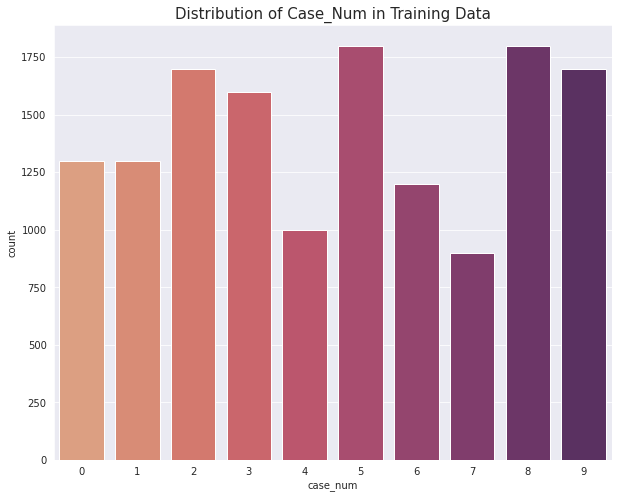

In [10]:
plt.figure(figsize=(10, 8))

sns.countplot(x='case_num', data=train, palette='flare')
plt.title('Distribution of Case_Num in Training Data', fontsize=15)

plt.show()

<h4>Next step is to analyse the annotations. First, we will focus at the number of features in annotations and then we will consider the most important words in the annotations.</h4> 

Number of Rows with no Annotations - 4399
Number of Rows with Annotations - 9901


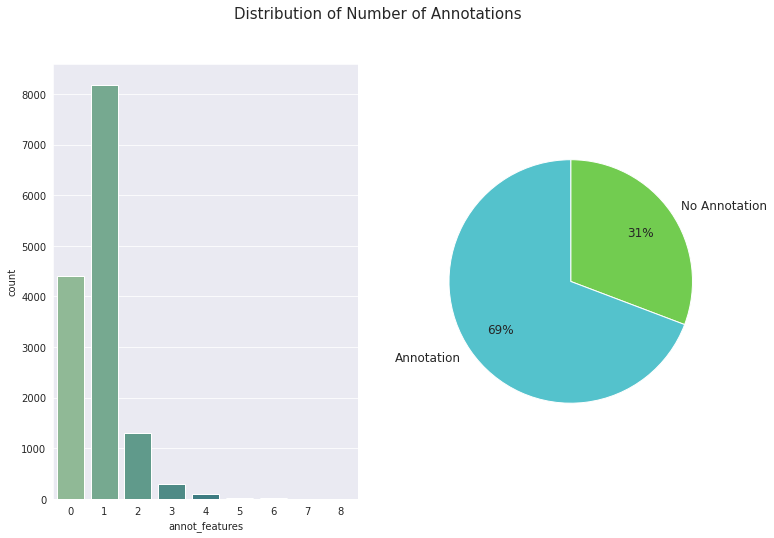

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
fig.suptitle('Distribution of Number of Annotations', size=15)
train['annot_features'] = train['annotation'].apply(lambda x : len(ast.literal_eval(x))) 
sns.countplot(x=train['annot_features'], palette='crest', ax=ax[0])

sizes = []
no_annotations = len(train[train['annot_features']==0])
sizes.append(no_annotations)
annotated = len(train) - len(train[train['annot_features']==0])
sizes.append(annotated)

print('Number of Rows with no Annotations -', no_annotations)
print('Number of Rows with Annotations -', annotated)

labels = ['No Annotation', 'Annotation']
colors = ['#72CC50', '#54C2CC']
ax[1].pie(sizes, colors=colors, startangle=90, labels=labels,
        autopct='%1.0f%%', pctdistance=0.7,textprops={'fontsize':12}, counterclock=False)

plt.show()

In [12]:
def annot_list(annotation):
    text = [word for words in ast.literal_eval(annotation) for word in words.split()]
    return text


train['text'] = train['annotation'].apply(lambda x : annot_list(x))
top = Counter([word for words in train['text'] for word in words])


df_temp = pd.DataFrame(top.most_common(25))
df_temp.columns = ['Common_words','count']

fig = px.bar(df_temp, x='count', y='Common_words', title='Most Common Words(including stopwords) in Annotations', orientation='h', width=800,height=600, color='Common_words')
fig.show()


In [13]:
def stopwords_remove(annotation):
    text = [word for words in ast.literal_eval(annotation) for word in words.split() if word not in set(nltk.corpus.stopwords.words('english'))]
    return text

train['text'] = train['annotation'].apply(lambda x : stopwords_remove(x))

top = Counter([word for words in train['text'] for word in words])
df_temp = pd.DataFrame(top.most_common(25))
df_temp.columns = ['Common_words','count']

fig = px.bar(df_temp, x='count', y='Common_words', title='Most Common Words(including stopwords) in Annotations', orientation='h', width=800,height=600, color='Common_words')
fig.show()

# Feuture Data

#### Now we will analyse the features data. We will start by looking the distribution of case_num.

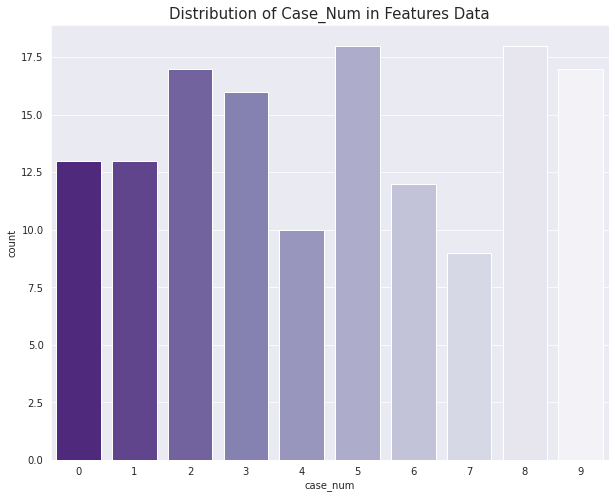

In [14]:
plt.figure(figsize=(10, 8))

sns.countplot(x='case_num', data=feature, palette = 'Purples_r')
plt.title('Distribution of Case_Num in Features Data', fontsize=15)

plt.show()

#### Then we will inspect some feature_text properties like number of words in it and the average word length distributions.

In [15]:
text_len = feature['feature_text'].str.split('-').map(lambda x : len(x))
#text_len = [len(i) for i in text_len]
fig = ff.create_distplot([text_len], ['feature'], colors=['#2ca02c'])
fig.update_layout(title_text='Word Count Distribution')
fig.show()

In [16]:
avg_word_len = feature['feature_text'].str.split('-').apply(lambda x : [len(i) for i in x]).map(lambda x : np.mean(x))
fig = ff.create_distplot([avg_word_len], ['feature'], colors=['#ffa408'])
fig.update_layout(title_text='Average Word Length Distribution')
fig.show()

# Patient Notes Data

#### Lastly, we will analyse the patient_notes data. We will start by looking the distribution of case_num.

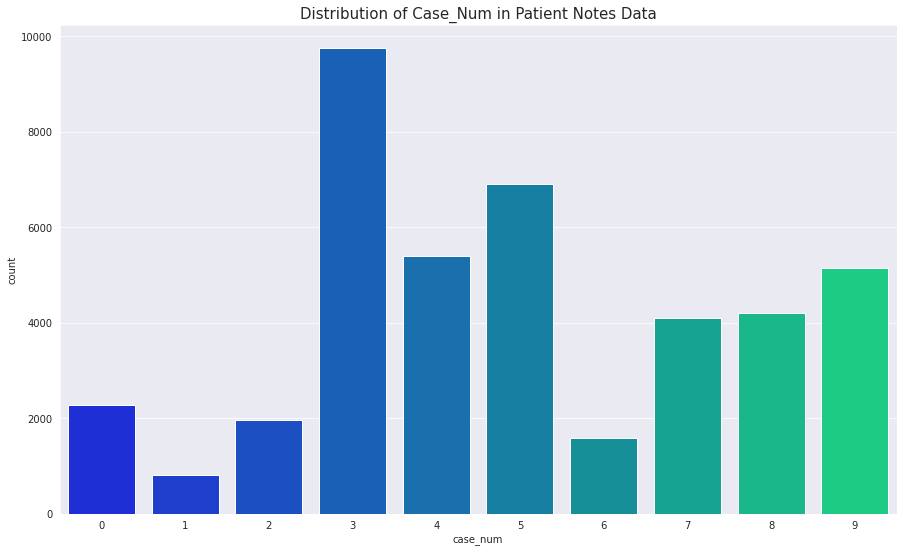

In [17]:
plt.figure(figsize=(15, 9))

sns.countplot(x='case_num', data=patient_note, palette = 'winter')
plt.title('Distribution of Case_Num in Patient Notes Data', fontsize=15)

plt.show()

#### Then similarly we will inspect some patient history notes properties like number of words in it and the average word length distributions.

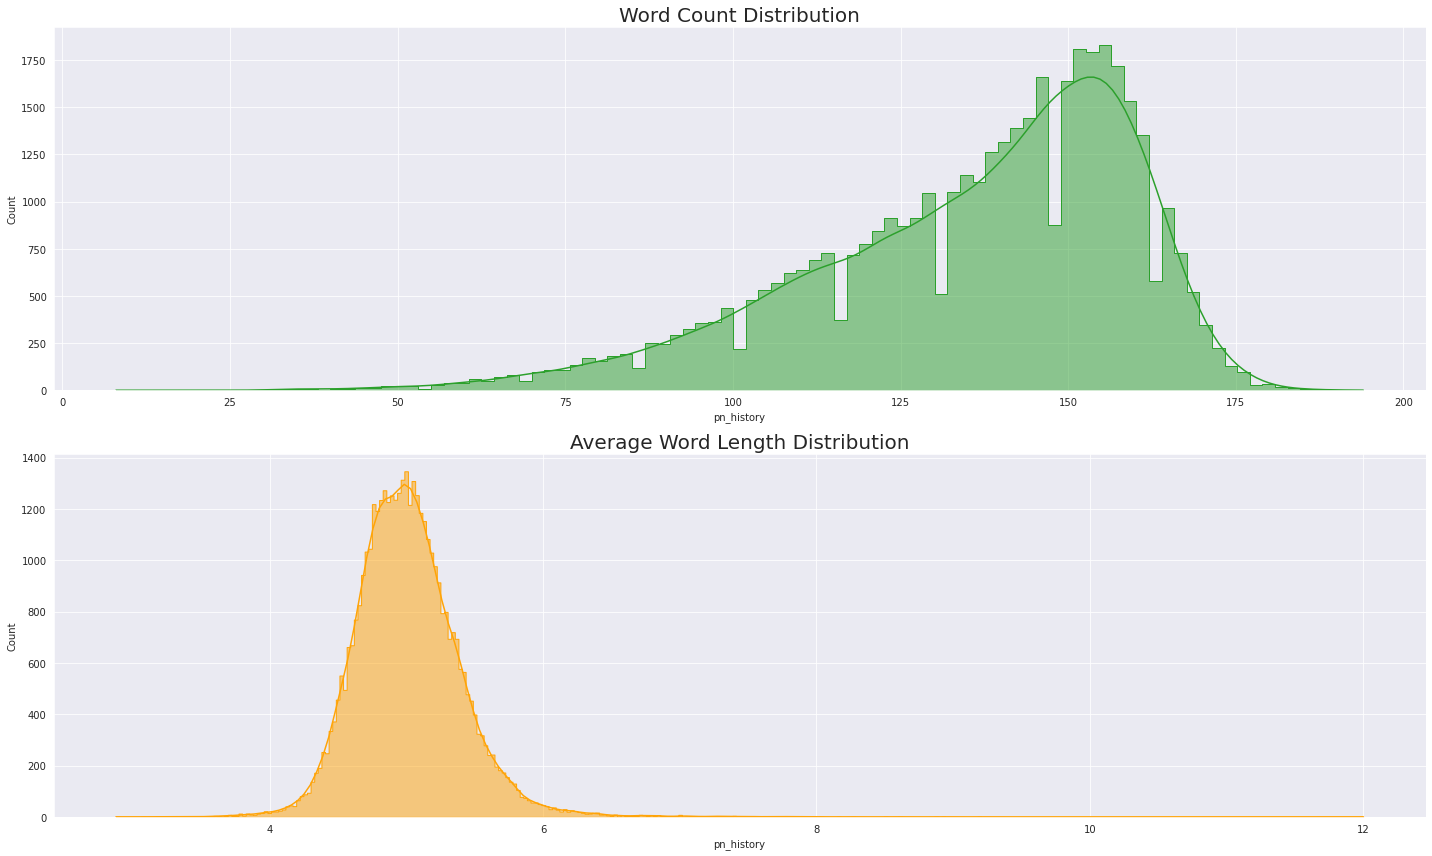

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

text_len = patient_note['pn_history'].str.split().map(lambda x : len(x))
sns.histplot(text_len, element="step", kde=True, color='#2ca02c', ax=ax[0])
ax[0].set_title('Word Count Distribution', size=20)

avg_word_len = patient_note['pn_history'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x : np.mean(x))
sns.histplot(avg_word_len, element="step", kde=True, color='#ffa408', ax=ax[1])
ax[1].set_title('Average Word Length Distribution', size=20)

plt.tight_layout()
plt.show()

# Anotations Visualization

In [19]:
# Reference - https://www.kaggle.com/vanguarde/nbme-eda
nlp = spacy.blank('en')
loc = list(train.loc[(train.pn_num==224) & (train.location!='[]'), 'location'].str.replace("['", "", regex=False).str.replace("']", "", regex=False))
text = patient_note[patient_note.pn_num==224].pn_history.values[0]
doc = nlp.make_doc(text)
ents = []
for l in loc:
    start, end = l.split(' ')
    ent = doc.char_span(int(start), int(end), label='annotation')
    ents.append(ent)
doc.ents = ents
color = {"Annotation": '#A32EFF'}
displacy.render(doc, style="ent", jupyter=True, options={'colors': color})